In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Parameter selection, Validation, and Testing
Most models have parameters that influence how complex a model they can learn. Remember using KNeighborsRegressor. If we change the number of neighbors we consider, we get a smoother and smoother prediction:

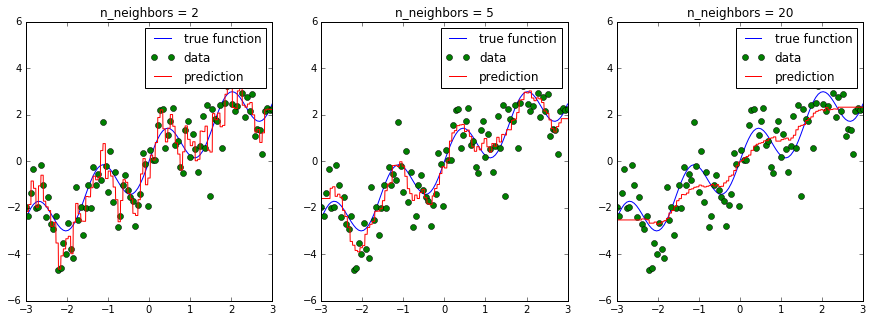


# Hyperparameters, Over-fitting, and Under-fitting
Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of k in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of `n_neighbors`:

n_neighbors: 1,
	scores: [0.42159056 0.7009657  0.35125364 0.57086185 0.66552489], 
	average score: 0.542039
n_neighbors: 3,
	scores: [0.78085058 0.7178187  0.78864387 0.79993321 0.51137755], 
	average score: 0.719725
n_neighbors: 5,
	scores: [0.64698975 0.79969958 0.8089053  0.81479002 0.58011466], 
	average score: 0.730100
n_neighbors: 10,
	scores: [0.84629084 0.78207425 0.51516553 0.70492838 0.85823113], 
	average score: 0.741338
n_neighbors: 20,
	scores: [0.58843541 0.78822718 0.72268902 0.59974942 0.61529759], 
	average score: 0.662880


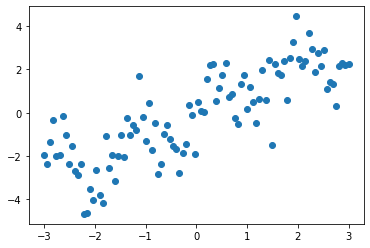

In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

plt.plot(X, y, 'o')

cv = KFold(shuffle=True)

# for each parameter setting do cross-validation:
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d,\n\tscores: %s, \n\taverage score: %f" % (n_neighbors, scores, np.mean(scores)))

There is a function in scikit-learn, called `validation_plot` to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

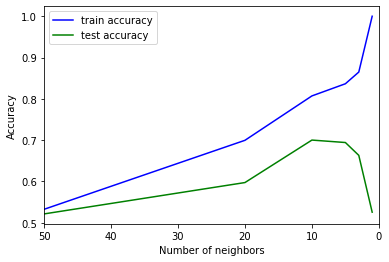

In [3]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors", param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_scores.mean(axis=1), 'b', label="train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis=1), 'g', label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
plt.xlim([50, 0])
plt.legend(loc="best");

<div class="alert alert-warning">
    <p>Note that many neighbors mean a "smooth" or "simple" model, so the plot uses a reverted x axis.</p>
</div>

If multiple parameters are important, like the parameters C and gamma in an SVM, all possible combinations are tried:

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.098956
C: 0.001000, gamma: 0.010000, average score: -0.110815
C: 0.001000, gamma: 0.100000, average score: -0.287889
C: 0.001000, gamma: 1.000000, average score: -0.049829
C: 0.010000, gamma: 0.001000, average score: -0.027997
C: 0.010000, gamma: 0.010000, average score: -0.020773
C: 0.010000, gamma: 0.100000, average score: 0.028781
C: 0.010000, gamma: 1.000000, average score: 0.094466
C: 0.100000, gamma: 0.001000, average score: -0.368545
C: 0.100000, gamma: 0.010000, average score: 0.190617
C: 0.100000, gamma: 0.100000, average score: 0.451233
C: 0.100000, gamma: 1.000000, average score: 0.504205
C: 1.000000, gamma: 0.001000, average score: 0.074628
C: 1.000000, gamma: 0.010000, average score: 0.574406
C: 1.000000, gamma: 0.100000, average score: 0.624914
C: 1.000000, gamma: 1.000000, average score: 0.689425
C: 10.000000, gamma: 0.001000, average score: 0.602687
C: 10.000000, gamma: 0.010000, average score: 0.573357
C: 10.000000, gamma

As this is such a very common pattern, there is a built-in class for this in scikit-learn, `GridSearchCV`. GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

One of the great things about `GridSearchCV` is that it is a meta-estimator. It takes an estimator like SVR above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor. So we can call `fit` on it, to train it:

In [6]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]})

What `fit` does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use `predict` or `score`:

In [7]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64

In [8]:
grid.best_score_

0.7214357795607078

In [9]:
grid.best_params_

{'C': 10, 'gamma': 1}

In [15]:
grid.cv_results_

{'mean_fit_time': array([0.00110292, 0.00049372, 0.0006072 , 0.00044484, 0.00060019,
        0.00039992, 0.0006    , 0.00039992, 0.00080004, 0.00040007,
        0.00019999, 0.00059996, 0.00059996, 0.00019989, 0.00059996,
        0.0006    , 0.00039983, 0.00040007, 0.0006001 , 0.00080004]),
 'std_fit_time': array([9.61109030e-05, 4.47242711e-04, 5.10938867e-04, 4.55740152e-04,
        4.90064308e-04, 4.89804186e-04, 4.89901406e-04, 4.89804325e-04,
        4.00019104e-04, 4.89979242e-04, 3.99971008e-04, 4.89862534e-04,
        4.89862441e-04, 3.99780273e-04, 4.89862441e-04, 4.89901406e-04,
        4.89687246e-04, 4.89979451e-04, 4.89979451e-04, 4.00019559e-04]),
 'mean_score_time': array([0.00057921, 0.00040498, 0.00058956, 0.00055203, 0.00039878,
        0.00039978, 0.00039992, 0.00039978, 0.00020008, 0.00039988,
        0.00055585, 0.00020003, 0.00019999, 0.00079999, 0.00039997,
        0.00039992, 0.00039997, 0.00039992, 0.00039997, 0.00040016]),
 'std_score_time': array([0.00050402, 

In [10]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [19]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001103,0.000096,0.000579,0.000504,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.856250,-0.389870,-0.125180,-0.033418,-0.067523,-0.294448,0.307575,20
1,0.000494,0.000447,0.000405,0.000496,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.850671,-0.385509,-0.121165,-0.030851,-0.064845,-0.290608,0.306539,19
2,0.000607,0.000511,0.000590,0.000498,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",-0.828029,-0.364768,-0.104650,-0.020567,-0.052752,-0.274153,0.302339,16
3,0.000445,0.000456,0.000552,0.000459,0.001,1,"{'C': 0.001, 'gamma': 1}",-0.832807,-0.365919,-0.108863,-0.023552,-0.054587,-0.277146,0.302920,17
4,0.000600,0.000490,0.000399,0.000488,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.850065,-0.385117,-0.120719,-0.030559,-0.064586,-0.290209,0.306430,18
5,0.000400,0.000490,0.000400,0.000490,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",-0.813453,-0.342062,-0.082245,-0.003436,-0.038180,-0.255875,0.303178,15
6,0.000600,0.000490,0.000400,0.000490,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",-0.586546,-0.160143,0.064044,0.108504,0.066200,-0.101588,0.260130,12
7,0.000400,0.000490,0.000400,0.000490,0.01,1,"{'C': 0.01, 'gamma': 1}",-0.607697,-0.187088,0.036994,0.082753,0.045678,-0.125872,0.258991,13


In [21]:
cv_results_tiny = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head(6)

,param_C,param_gamma,mean_test_score
19,10,1,0.721436
15,1,1,0.677114
18,10,0.1,0.613302
14,1,0.1,0.608902
17,10,0.01,0.548461
13,1,0.01,0.521986


There is a problem with using this score for evaluation, however. You might be making what is called a multiple hypothesis testing error. If you try very many parameter settings, some of them will work better just by chance, and the score that you obtained might not reflect how your model would perform on new unseen data. Therefore, it is good to split off a separate test-set before performing grid-search. This pattern can be seen as a training-validation-test split, and is common in machine learning:
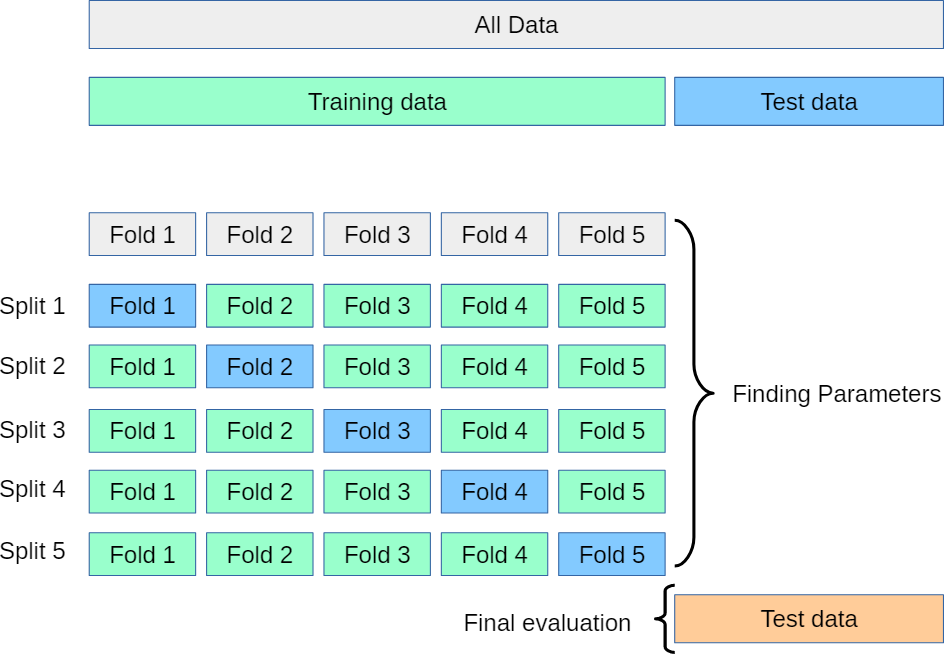

We can do this very easily by splitting of some test data using `train_test_split`, training `GridSearchCV` on the training set, and applying the score method to the test set:



In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.7262035177984737

In [26]:
grid.best_params_

{'C': 10, 'gamma': 1}

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long. You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with `ShuffleSplit` cross-validation with a single iteration:

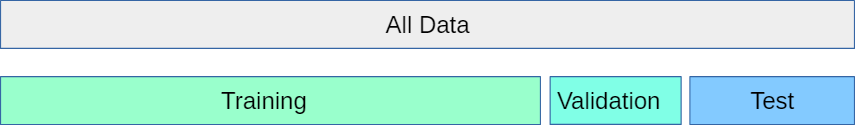

In [27]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV 1/1] END .............C=0.001, gamma=0.001;, score=-0.211 total time=   0.0s
[CV 1/1] END ..............C=0.001, gamma=0.01;, score=-0.208 total time=   0.0s
[CV 1/1] END ...............C=0.001, gamma=0.1;, score=-0.197 total time=   0.0s
[CV 1/1] END .................C=0.001, gamma=1;, score=-0.199 total time=   0.0s
[CV 1/1] END ..............C=0.01, gamma=0.001;, score=-0.208 total time=   0.0s
[CV 1/1] END ...............C=0.01, gamma=0.01;, score=-0.177 total time=   0.0s
[CV 1/1] END ................C=0.01, gamma=0.1;, score=-0.030 total time=   0.0s
[CV 1/1] END ..................C=0.01, gamma=1;, score=-0.049 total time=   0.0s
[CV 1/1] END ...............C=0.1, gamma=0.001;, score=-0.174 total time=   0.0s
[CV 1/1] END .................C=0.1, gamma=0.01;, score=0.083 total time=   0.0s
[CV 1/1] END ..................C=0.1, gamma=0.1;, score=0.521 total time=   0.0s
[CV 1/1] END ....................C=0.1, gamma=1;

0.7262035177984737

This is much faster, but might result in worse hyperparameters and therefore worse results.

In [28]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7262035177984737